<a href="https://colab.research.google.com/github/MZiaAfzal71/Edge-Aware-GNN/blob/main/Models/CV_Aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cross-Validation (CV) Aggregation

To obtain robust and unbiased performance estimates, results from cross-validation
are aggregated across all folds and repeats.

For repeated cross-validation:
- A **5×5 repeated cross-validation** scheme is used
- Each repetition consists of 5 non-overlapping folds
- Model training and evaluation are performed independently for each fold

Performance metrics—including **RMSE**, **MAE**, and **R²**—are computed on the
validation set for every fold and repeat.

Final cross-validation performance is reported as:
- The **mean** of each metric across all folds and repeats
- The corresponding **standard deviation**, reflecting performance stability

This aggregation strategy:
- Reduces variance caused by a single data split
- Provides a more reliable estimate of model generalization
- Enables fair comparison between different models evaluated on identical splits

All reported CV metrics in this notebook follow this aggregation protocol.




In [1]:
# 1️⃣ Fetch data
!git clone https://github.com/MZiaAfzal71/Edge-Aware-GNN.git

Cloning into 'Edge-Aware-GNN'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 136 (delta 58), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (136/136), 234.75 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [2]:
# 2️⃣ Change current/working directory
%cd Edge-Aware-GNN/Results

/content/Edge-Aware-GNN/Results


In [3]:
# ============================================================
# Imports
# ============================================================
import pandas as pd
from pathlib import Path

import numpy as np
from scipy.stats import wilcoxon
from itertools import combinations
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# Plot styling
# ============================================================
sns.set_style("whitegrid")


# ============================================================
# Configuration
# ============================================================

# Repeated k-fold CV result files
model_files_cv = {
    "Chemprop"                : "chemprop repeated kfold.csv",
    "Chemprop + Descriptors"  : "chemprop repeated kfold with descriptors.csv",
    "DA Edge-Aware GNN"       : "Fold results descriptor augmented edge aware GNN.csv",
    "Edge-Aware GNN"          : "Fold Results Edge aware GNN.csv",
    "Random Forest"           : "Folds results Random Forest.csv",
    "XGBoost"                 : "Folds results XGBoost.csv"
}

# Scaffold split / ensemble result files
model_files_sc = {
    "Chemprop"                : "chemprop ensemble scaffold.csv",
    "Chemprop + Descriptors"  : "chemprop ensemble with descriptors scaffold.csv",
    "DA Edge-Aware GNN"       : "Ensemble results descriptor augmented edge aware GNN Scaffold.csv",
    "Edge-Aware GNN"          : "Ensemble results edge aware GNN Scaffold.csv",
    "Random Forest"           : "Ensemble results Random Forest Scaffold.csv",
    "XGBoost"                 : "Ensemble results XGBoost Scaffold.csv"
}

# Mapping of metric short names to CSV column names
metrics = {
    "rmse": "best_val_rmse",
    "mae" : "best_val_mae",
    "r2"  : "best_val_r2"
}


# ============================================================
# Containers for aggregated results
# ============================================================

# Per-fold CV results
cv_dict = {
    "model"      : [],
    "fold"       : [],
    "rmse_train" : [],
    "rmse_val"   : [],
    "mae_train"  : [],
    "mae_val"    : [],
    "r2_train"   : [],
    "r2_val"     : []
}

# Per-ensemble scaffold split results
sc_dict = {
    "model"      : [],
    "ensem"      : [],
    "rmse_train" : [],
    "rmse_val"   : [],
    "mae_train"  : [],
    "mae_val"    : [],
    "r2_train"   : [],
    "r2_val"     : []
}


# ============================================================
# Load repeated k-fold CV results
# ============================================================

for model_name, fname in model_files_cv.items():
    df = pd.read_csv(fname)

    fold_id = 1
    for _, row in df.iterrows():
        cv_dict["model"].append(model_name)
        cv_dict["fold"].append(fold_id)

        cv_dict["rmse_train"].append(row["best_train_rmse"])
        cv_dict["rmse_val"].append(row["best_val_rmse"])

        cv_dict["mae_train"].append(row["best_train_mae"])
        cv_dict["mae_val"].append(row["best_val_mae"])

        cv_dict["r2_train"].append(row["best_train_r2"])
        cv_dict["r2_val"].append(row["best_val_r2"])

        fold_id += 1


# ============================================================
# Load scaffold split / ensemble results
# ============================================================

for model_name, fname in model_files_sc.items():
    df = pd.read_csv(fname)

    ensem_id = 1
    for _, row in df.iterrows():
        sc_dict["model"].append(model_name)
        sc_dict["ensem"].append(ensem_id)

        sc_dict["rmse_train"].append(row["best_train_rmse"])
        sc_dict["rmse_val"].append(row["best_val_rmse"])

        sc_dict["mae_train"].append(row["best_train_mae"])
        sc_dict["mae_val"].append(row["best_val_mae"])

        sc_dict["r2_train"].append(row["best_train_r2"])
        sc_dict["r2_val"].append(row["best_val_r2"])

        ensem_id += 1


# ============================================================
# Compute summary statistics (mean ± std)
# ============================================================

rows = []

for (model_name, cv_file), (_, sc_file) in zip(
        model_files_cv.items(),
        model_files_sc.items()
    ):

    df_cv = pd.read_csv(cv_file)
    df_sc = pd.read_csv(sc_file)

    summary = {"Model": model_name}

    for key, col in metrics.items():
        summary[f"cv_{key}_mean"] = df_cv[col].mean()
        summary[f"cv_{key}_std"]  = df_cv[col].std()

        summary[f"sc_{key}_mean"] = df_sc[col].mean()
        summary[f"sc_{key}_std"]  = df_sc[col].std()

    rows.append(summary)

summary_df = pd.DataFrame(rows)


# ============================================================
# Format results for LaTeX tables
# ============================================================

for m in metrics:
    summary_df[f"cv_{m}"] = (
        summary_df[f"cv_{m}_mean"].map("{:.3f}".format)
        + " $\\pm$ "
        + summary_df[f"cv_{m}_std"].map("{:.3f}".format)
    )

    summary_df[f"sc_{m}"] = (
        summary_df[f"sc_{m}_mean"].map("{:.3f}".format)
        + " $\\pm$ "
        + summary_df[f"sc_{m}_std"].map("{:.3f}".format)
    )

summary_df = summary_df[
    ["Model", "cv_rmse", "cv_mae", "cv_r2", "sc_rmse", "sc_mae", "sc_r2"]
]

print(summary_df)


# ============================================================
# Save outputs
# ============================================================

summary_df.to_csv("cv_validation_summary.csv", index=False)

cv_df = pd.DataFrame(cv_dict)
sc_df = pd.DataFrame(sc_dict)


                    Model            cv_rmse             cv_mae  \
0                Chemprop  0.679 $\pm$ 0.050  0.501 $\pm$ 0.031   
1  Chemprop + Descriptors  0.623 $\pm$ 0.250  0.421 $\pm$ 0.078   
2       DA Edge-Aware GNN  0.597 $\pm$ 0.066  0.430 $\pm$ 0.040   
3          Edge-Aware GNN  0.670 $\pm$ 0.034  0.486 $\pm$ 0.021   
4           Random Forest  0.631 $\pm$ 0.052  0.457 $\pm$ 0.030   
5                 XGBoost  0.571 $\pm$ 0.044  0.409 $\pm$ 0.026   

               cv_r2            sc_rmse             sc_mae              sc_r2  
0  0.885 $\pm$ 0.018  1.002 $\pm$ 0.029  0.775 $\pm$ 0.023  0.751 $\pm$ 0.012  
1  0.898 $\pm$ 0.134  0.918 $\pm$ 0.032  0.703 $\pm$ 0.016  0.799 $\pm$ 0.014  
2  0.905 $\pm$ 0.025  0.818 $\pm$ 0.016  0.634 $\pm$ 0.012  0.827 $\pm$ 0.006  
3  0.884 $\pm$ 0.016  0.960 $\pm$ 0.026  0.752 $\pm$ 0.021  0.747 $\pm$ 0.034  
4  0.908 $\pm$ 0.015  0.933 $\pm$ 0.005  0.688 $\pm$ 0.003  0.740 $\pm$ 0.003  
5  0.925 $\pm$ 0.010  0.874 $\pm$ 0.012  0.658 $\p

In [4]:
latex_table_str = ""
for row in summary_df.iterrows():
  latex_table_str += row[1]["Model"] + ' & ' +  row[1]["cv_rmse"] + ' & ' + row[1]["cv_mae"] + ' & ' + row[1]["cv_r2"] + ' & '
  latex_table_str += row[1]["sc_rmse"] + ' & ' + row[1]["sc_mae"] + ' & ' + row[1]["sc_r2"] + "\\\\" + "\n"
print(latex_table_str)

Chemprop & 0.679 $\pm$ 0.050 & 0.501 $\pm$ 0.031 & 0.885 $\pm$ 0.018 & 1.002 $\pm$ 0.029 & 0.775 $\pm$ 0.023 & 0.751 $\pm$ 0.012\\
Chemprop + Descriptors & 0.623 $\pm$ 0.250 & 0.421 $\pm$ 0.078 & 0.898 $\pm$ 0.134 & 0.918 $\pm$ 0.032 & 0.703 $\pm$ 0.016 & 0.799 $\pm$ 0.014\\
DA Edge-Aware GNN & 0.597 $\pm$ 0.066 & 0.430 $\pm$ 0.040 & 0.905 $\pm$ 0.025 & 0.818 $\pm$ 0.016 & 0.634 $\pm$ 0.012 & 0.827 $\pm$ 0.006\\
Edge-Aware GNN & 0.670 $\pm$ 0.034 & 0.486 $\pm$ 0.021 & 0.884 $\pm$ 0.016 & 0.960 $\pm$ 0.026 & 0.752 $\pm$ 0.021 & 0.747 $\pm$ 0.034\\
Random Forest & 0.631 $\pm$ 0.052 & 0.457 $\pm$ 0.030 & 0.908 $\pm$ 0.015 & 0.933 $\pm$ 0.005 & 0.688 $\pm$ 0.003 & 0.740 $\pm$ 0.003\\
XGBoost & 0.571 $\pm$ 0.044 & 0.409 $\pm$ 0.026 & 0.925 $\pm$ 0.010 & 0.874 $\pm$ 0.012 & 0.658 $\pm$ 0.009 & 0.797 $\pm$ 0.009\\



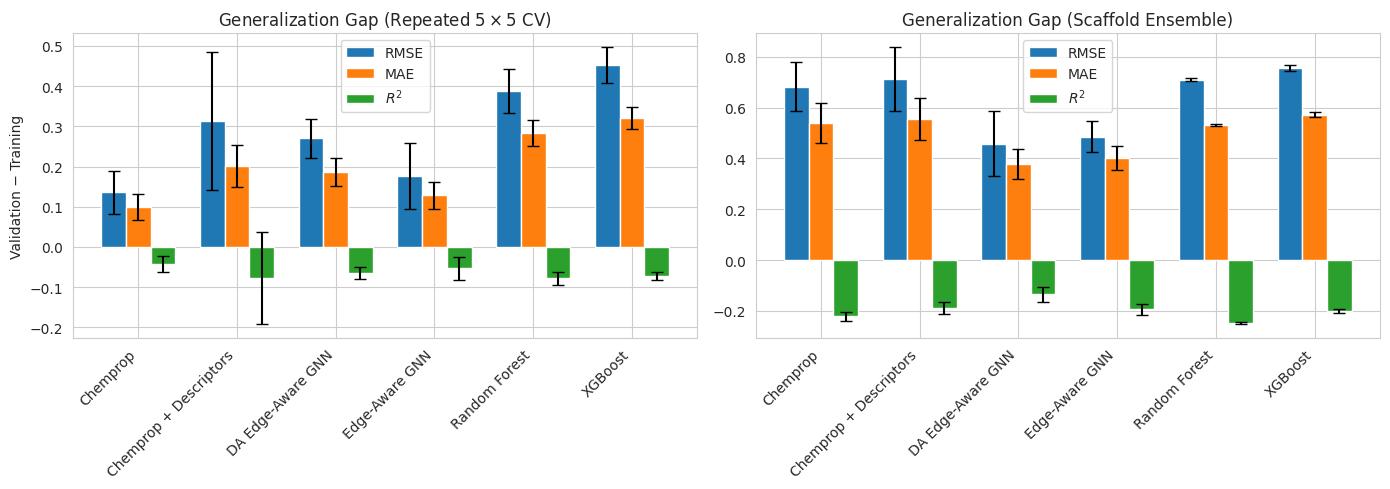

In [5]:
# ============================================================
# Compute generalization gaps (Validation − Training)
# ============================================================

# Add gap columns to both CV and scaffold DataFrames
for df in [cv_df, sc_df]:
    df["rmse_gap"] = df["rmse_val"] - df["rmse_train"]
    df["mae_gap"]  = df["mae_val"]  - df["mae_train"]
    df["r2_gap"]   = df["r2_val"]   - df["r2_train"]


# ============================================================
# Aggregate mean and standard deviation per model
# ============================================================

cv_gap = (
    cv_df
    .groupby("model")[["rmse_gap", "mae_gap", "r2_gap"]]
    .agg(["mean", "std"])
)

scaf_gap = (
    sc_df
    .groupby("model")[["rmse_gap", "mae_gap", "r2_gap"]]
    .agg(["mean", "std"])
)


# ============================================================
# Plot configuration
# ============================================================

models = cv_gap.index
x = np.arange(len(models))
width = 0.25


# ============================================================
# Create figure
# ============================================================

fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 5),
    sharey=False
)


# ============================================================
# LEFT PANEL: Repeated CV generalization gap
# ============================================================

axes[0].bar(
    x - width,
    cv_gap["rmse_gap"]["mean"],
    width,
    yerr=cv_gap["rmse_gap"]["std"],
    capsize=4,
    label="RMSE"
)

axes[0].bar(
    x,
    cv_gap["mae_gap"]["mean"],
    width,
    yerr=cv_gap["mae_gap"]["std"],
    capsize=4,
    label="MAE"
)

axes[0].bar(
    x + width,
    cv_gap["r2_gap"]["mean"],
    width,
    yerr=cv_gap["r2_gap"]["std"],
    capsize=4,
    label=r"$R^2$"
)

axes[0].set_title("Generalization Gap (Repeated $5\\times5$ CV)")
axes[0].set_ylabel("Validation − Training")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha="right")
axes[0].legend()


# ============================================================
# RIGHT PANEL: Scaffold ensemble generalization gap
# ============================================================

axes[1].bar(
    x - width,
    scaf_gap["rmse_gap"]["mean"],
    width,
    yerr=scaf_gap["rmse_gap"]["std"],
    capsize=4,
    label="RMSE"
)

axes[1].bar(
    x,
    scaf_gap["mae_gap"]["mean"],
    width,
    yerr=scaf_gap["mae_gap"]["std"],
    capsize=4,
    label="MAE"
)

axes[1].bar(
    x + width,
    scaf_gap["r2_gap"]["mean"],
    width,
    yerr=scaf_gap["r2_gap"]["std"],
    capsize=4,
    label=r"$R^2$"
)

axes[1].set_title("Generalization Gap (Scaffold Ensemble)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha="right")
axes[1].legend()


# ============================================================
# Finalize figure
# ============================================================

plt.tight_layout()
plt.savefig("gen_gap_cv_vs_scaffold.pdf")
plt.show()


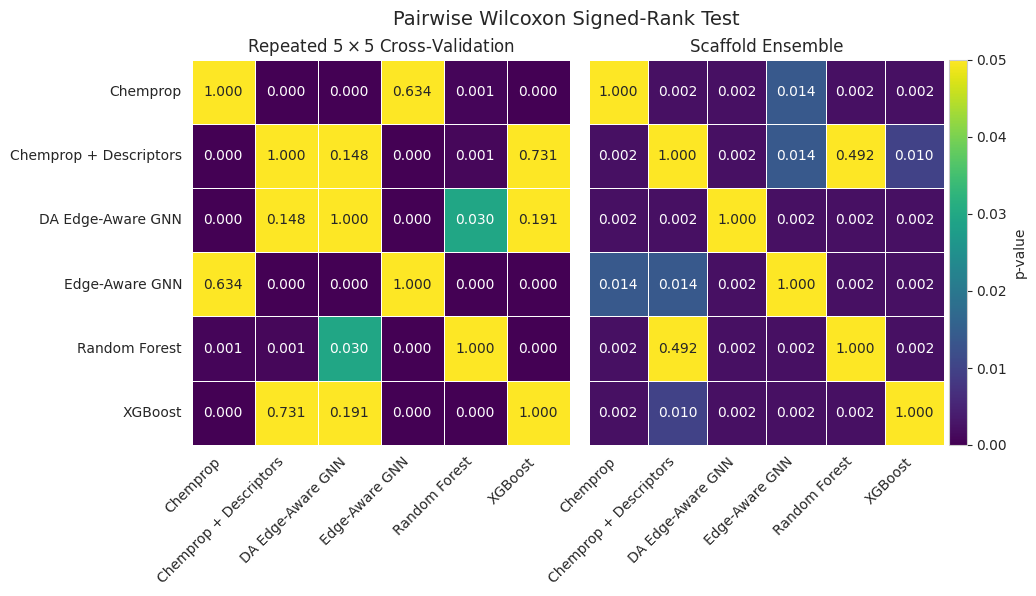

In [6]:
# ============================================================
# Wilcoxon signed-rank test utility
# ============================================================

def wilcoxon_test(df, model_a, model_b, metric):
    """
    Compute paired Wilcoxon signed-rank test between two models
    for a given metric.
    """
    a = df[df["model"] == model_a][metric].values
    b = df[df["model"] == model_b][metric].values

    stat, p = wilcoxon(a, b)
    return p


# ============================================================
# Configuration
# ============================================================

models = [
    "Chemprop",
    "Chemprop + Descriptors",
    "DA Edge-Aware GNN",
    "Edge-Aware GNN",
    "Random Forest",
    "XGBoost"
]

metric = "rmse_val"


# ============================================================
# Initialize p-value matrices
# ============================================================

cv_pval_matrix = pd.DataFrame(
    np.ones((len(models), len(models))),
    index=models,
    columns=models
)

sc_pval_matrix = pd.DataFrame(
    np.ones((len(models), len(models))),
    index=models,
    columns=models
)


# ============================================================
# Compute pairwise Wilcoxon p-values
# ============================================================

for m1, m2 in combinations(models, 2):

    # Repeated CV
    p_cv = wilcoxon_test(cv_df, m1, m2, metric)

    cv_pval_matrix.loc[m1, m2] = p_cv
    cv_pval_matrix.loc[m2, m1] = p_cv

    # Scaffold ensemble
    p_sc = wilcoxon_test(sc_df, m1, m2, metric)

    sc_pval_matrix.loc[m1, m2] = p_sc
    sc_pval_matrix.loc[m2, m1] = p_sc


# ============================================================
# Visualization: Heatmaps
# ============================================================

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 5),
    gridspec_kw={"wspace": 0.05}
)


# ------------------------------------------------------------
# Left panel: Repeated CV
# ------------------------------------------------------------

sns.heatmap(
    cv_pval_matrix,
    ax=axes[0],
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar=False,
    linewidths=0.5,
    vmin=0,
    vmax=0.05
)


# ------------------------------------------------------------
# Right panel: Scaffold ensemble
# ------------------------------------------------------------

hm = sns.heatmap(
    sc_pval_matrix,
    ax=axes[1],
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar=False,          # disable internal colorbar
    linewidths=0.5,
    vmin=0,
    vmax=0.05
)


# ------------------------------------------------------------
# Shared external colorbar
# ------------------------------------------------------------

divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(
    hm.collections[0],
    cax=cax,
    label="p-value"
)


# ============================================================
# Formatting
# ============================================================

axes[0].set_title("Repeated $5\\times5$ Cross-Validation")
axes[1].set_title("Scaffold Ensemble")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

axes[0].tick_params(axis="y", labelleft=True)
axes[1].tick_params(axis="y", labelleft=False)

plt.suptitle(
    "Pairwise Wilcoxon Signed-Rank Test",
    fontsize=14
)

plt.savefig(
    "wilcoxon test.pdf",
    bbox_inches="tight",
    pad_inches=0.05
)

plt.show()
